In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import keras.backend as K
import os
import random
import matplotlib.pyplot as plt
tfk = tf.keras
tfkl = tf.keras.layers
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Random seed for reproducibility
seed = 21
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Versione di TensorFlow:", tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

2024-02-12 16:09:43.760135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 16:09:43.760180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 16:09:43.768575: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 16:09:44.448771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0
Num GPUs Available:  2
Versione di TensorFlow: 2.14.0


2024-02-12 16:09:55.483082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 16:09:55.485145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 16:09:55.596177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
#Parameters

path_images = "/dataset/new_simones/AerialWaste2"
path_json = "/home/simones95/EnvCrime"
AW1 = False
AW2 = not AW1

oversampling = True

batch_size = 8
spatial_resolution = 20
max_dim = 1088 #1088
max_shape = tf.constant((max_dim, max_dim))

learning_rate = 1.0e-5
l2 = 1.0e-1 #1

box_size = 128
num_boxes = 32

FPN = True

2023-12-22 11:47:15.900480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 11:47:15.902397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 11:47:15.904316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_data(name_json):
    # Load dataset for binary classification
    dataset = json.load(open(os.path.join(path_json, name_json)))
    if 'training' in name_json:
        pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_candidate_location']] for d in dataset['images']]
    else:
        if AW1: 
            pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_candidate_location']] for d in dataset['images']]
        else:
            pairs = [[os.path.join(path_images, 'images', d['file_name']), d['is_suspicius_location']] for d in dataset['images']]
            
    #Shuffle the pairs
    random.shuffle(pairs)
    
    # Extract info_images and their binary labels
    info_images, binary_labels = zip(*pairs)
    info_images = list(info_images)
    binary_labels = list(binary_labels)
    
    return info_images, binary_labels

if AW1:
    training_json = "training_aw1.json"
    testing_json = "testing_aw1.json"
elif AW2:
    training_json = "training_aw2.json"
    testing_json = "testing_aw2.json"

training_info_images, training_binary_labels = load_data(training_json)
num_samples_training = int(len(training_info_images) * 0.8)
validation_info_images, validation_binary_labels = training_info_images[num_samples_training:], training_binary_labels[num_samples_training:]
training_info_images, training_binary_labels = training_info_images[:num_samples_training], training_binary_labels[:num_samples_training]
testing_info_images, testing_binary_labels = load_data(testing_json)

print("Training: ", len(training_info_images), " ", len(training_info_images)/10434)
print("Validation: ", len(validation_info_images), " ", len(validation_info_images)/10434)
print("Testing: ", len(testing_info_images), " ", len(testing_info_images)/10434)

print("Training - Positive: ", sum(training_binary_labels), " - Negative: ", len(training_binary_labels) - sum(training_binary_labels))
print("Validation - Positive: ", sum(validation_binary_labels), " - Negative: ", len(validation_binary_labels) - sum(validation_binary_labels))
print("Testing - Positive: ", sum(testing_binary_labels), " - Negative: ", len(testing_binary_labels) - sum(testing_binary_labels))

Training:  6697   0.6418439716312057
Validation:  1675   0.16053287329883076
Testing:  2605   0.24966455817519648
Training - Positive:  2237  - Negative:  4460
Validation - Positive:  556  - Negative:  1119
Testing - Positive:  866  - Negative:  1739


In [4]:
def RandomOversampling(info_images, binary_labels):
    upsampling_factor = len(binary_labels)-2*sum(binary_labels)
    positive_indices = [i for i, value in enumerate(binary_labels) if value == 1]
    random.shuffle(positive_indices)
    for i in range(upsampling_factor):
        if i < len(positive_indices):
            info_images.append(info_images[positive_indices[i]])
            binary_labels.append(binary_labels[positive_indices[i]])
        
    upsampling_factor = len(binary_labels)-2*sum(binary_labels)
    if upsampling_factor > 0:
        info_images, binary_labels = RandomOversampling(info_images, binary_labels)
        
    random.seed(seed)
    random.shuffle(info_images)
    random.seed(seed)
    random.shuffle(binary_labels)
    
    return info_images, binary_labels

if oversampling:
    training_info_images, training_binary_labels = RandomOversampling(training_info_images, training_binary_labels)

print("Training - Positive: ", sum(training_binary_labels), " - Negative: ", len(training_binary_labels) - sum(training_binary_labels))

Training - Positive:  4460  - Negative:  4460


In [6]:
# Train Custom Generator
def load(info_image, label):
    image = tf.io.read_file(info_image)
    image = tf.image.decode_png(image, channels=3)
    
    # Resize to a specific resolution
    shape = tf.shape(image)
    spatial_resolution_image = 210 * 100 / tf.maximum(shape[0],shape[1])
    new_shape_image = tf.cast(tf.cast(shape, tf.float64) * (spatial_resolution_image / spatial_resolution), tf.int32)
    image = tf.image.resize(image, size=new_shape_image[0:2])
    
    # Padding
    offset = max_shape - new_shape_image[0:2]
    image = tf.image.pad_to_bounding_box(image, offset[0]//2, offset[1]//2, max_dim, max_dim)
    
    return image, label

def make_dataset(info_images, binary_labels):
    return tf.data.Dataset.from_tensor_slices((info_images, binary_labels))\
        .map(load)\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(training_info_images, training_binary_labels)
val_ds = make_dataset(validation_info_images, validation_binary_labels)
test_ds = make_dataset(testing_info_images, testing_binary_labels)

(8, 1088, 1088, 3)
tf.Tensor(1, shape=(), dtype=int32)


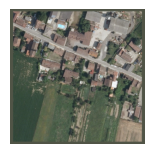

In [7]:
for i,o in train_ds.take(1):
  print(i.shape)
  plt.figure(figsize=(8, 8))
  for index in range(1):
    print(o[index])
    plt.subplot(2, 4, index+1)
    plt.imshow(i[index]/255, cmap='gray')
    plt.axis('off')

  plt.show()

In [8]:
class RandomNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, noise_factor, **kwargs):
        super(RandomNoiseLayer, self).__init__(**kwargs)
        self.noise_factor = noise_factor

    def call(self, inputs, training=None):
        if training:
            noisy_inputs = inputs + self.noise_factor * tf.random.normal(shape=tf.shape(inputs))
            noisy_inputs = tf.clip_by_value(noisy_inputs, 0.0, 255.0)
            return noisy_inputs
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({'noise_factor': self.noise_factor})
        return config

In [ ]:
class HideSeekLayer(tf.keras.layers.Layer):
    def __init__(self, box_size, num_boxes, **kwargs):
        super(HideSeekLayer, self).__init__(**kwargs)
        self.box_size = box_size
        self.num_boxes = num_boxes

    def call(self, inputs, training=None):
        if training:
          image_with_box = np.copy(inputs)
          for _ in range(self.num_boxes):
            point_x = np.random.randint(0, inputs.shape[1] - self.box_size)
            point_y = np.random.randint(0, inputs.shape[2] - self.box_size)
            image_with_box[:, point_x:point_x+self.box_size, point_y:point_y+self.box_size, :] = 0
          return image_with_box
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({'box_size': self.box_size})
        config.update({'box_number': self.box_number})
        return config

In [9]:
# Model

input = tfkl.Input(shape=(max_dim, max_dim, 3), name='input')
hideseek_image = HideSeekLayer(box_size,num_boxes)(input)
flipped_image = tfkl.RandomFlip(name='random_flip')(hideseek_image)
rotated_image = tfkl.RandomRotation(1, fill_mode='constant', fill_value=0.0, name='random_rotation')(flipped_image)
noised_image = RandomNoiseLayer(20.0, name='random_noise')(rotated_image)
brightened_image = tfkl.RandomBrightness(0.4, name='random_brightness')(noised_image)
contrasted_image = tfkl.RandomContrast(0.4, name='random_constrast')(brightened_image)
preprocessed_image = tf.keras.applications.inception_resnet_v2.preprocess_input(contrasted_image)
backbone = tfk.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=preprocessed_image, pooling='max')

if FPN:
    c2 = backbone.get_layer(name='activation_4').output
    c3 = backbone.get_layer(name='block35_10_ac').output
    c4 = backbone.get_layer(name='block17_20_ac').output
    c5 = backbone.get_layer(name='conv_7b_ac').output

    c2 = tfkl.Conv2D(filters=256, kernel_size=(13,13), strides=(1, 1), padding='valid', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="c2")(c2)
    c3 = tfkl.Conv2D(filters=256, kernel_size=(6,6), strides=(1, 1), padding='valid', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="c3")(c3)
    c4 = tfkl.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='valid', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="c4")(c4)
    c5 = tfkl.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="c5")(c5)

    # P4
    #p5x2 = tfkl.UpSampling2D(size=(2,2), interpolation="bilinear", name="p5x2")(c5)
    p5x2 = tfkl.Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="same", activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p5x2")(c5)
    c4_p5x2_concat = tfkl.Concatenate(name="c4_p5x2_concat")([c4, p5x2])
    p4 = tfkl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p4")(c4_p5x2_concat)

    # P3
    #p4x2 = tfkl.UpSampling2D(size=(2,2), interpolation="bilinear", name="p4x2")(p4)
    p4x2 = tfkl.Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="same", activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p4x2")(p4)
    c3_p4x2_concat = tfkl.Concatenate(name="c3_p4x2_concat")([c3, p4x2])
    p3 = tfkl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p3")(c3_p4x2_concat)

    # P2
    #p3x2 = tfkl.UpSampling2D(size=(2,2), interpolation="bilinear", name="p3x2")(p3)
    p3x2 = tfkl.Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="same", activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p3x2")(p3)
    c2_p3x2_concat = tfkl.Concatenate(name="c2_p3x2_concat")([c2, p3x2])
    p2 = tfkl.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name="p2")(c2_p3x2_concat)

    # Classification
    gap5 = tfkl.GlobalAveragePooling2D(name="gap5")(c5)
    gap4 = tfkl.GlobalAveragePooling2D(name="gap4")(p4)
    gap3 = tfkl.GlobalAveragePooling2D(name="gap3")(p3)
    gap2 = tfkl.GlobalAveragePooling2D(name="gap2")(p2)

    concat = tfkl.Concatenate(name="concat")([gap5, gap4, gap3, gap2])
    batchnorm1 = tfkl.BatchNormalization(name="batchnorm1")(concat)
    dense1 = tfkl.Dense(128, activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name='dense1')(batchnorm1)
    dense2 = tfkl.Dense(64, activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name='dense2')(dense1)
    dense3 = tfkl.Dense(32, activation="relu", kernel_regularizer=tfk.regularizers.l2(l2), name='dense3')(dense2)
    output = tfkl.Dense(1, activation="sigmoid", kernel_regularizer=tfk.regularizers.l2(l2), name='output')(dense3)
else:
    output = tfkl.Dense(1, activation="sigmoid", kernel_regularizer=tfk.regularizers.l2(l2), name='output')(backbone.output)

binary_classifier = tfk.Model(input, output, name="binary_classifier")

# Print the summary of the model
binary_classifier.summary()

Model: "binary_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, None, 3)]      0         []                            
                                                                                                  
 random_noise (RandomNoiseL  (None, None, None, 3)        0         ['input[0][0]']               
 ayer)                                                                                            
                                                                                                  
 random_brightness (RandomB  (None, None, None, 3)        0         ['random_noise[0][0]']        
 rightness)                                                                                       
                                                                                  

In [10]:
# Create a learning rate scheduler callback.
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_binary_accuracy", mode="max", factor=0.25, patience=5)
# Create an early stopping callback.
es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=8, restore_best_weights=True)

# Compile the model
binary_classifier.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=learning_rate),  # Optimizer
    # Loss function to minimize
    loss=tfk.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()]
)

# Train the model
history = binary_classifier.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds,
    callbacks=[lr_cb, es_cb],
)

binary_classifier.evaluate(test_ds, verbose=2)

binary_classifier.save("InceptionResNetV2_GAP_FPN_20cm_AW2_MultiDense5.h5")

Epoch 1/200


2023-12-22 11:48:00.893034: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-22 11:48:02.946591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-22 11:48:03.831109: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-22 11:48:13.966258: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd568722f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 11:48:13.966331: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-22 11:48:13.974825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-22 11:48:14.081442: I ./tensorflow/compiler/jit/device_compil

1115/1115 [==============================] - 1059s 839ms/step - loss: 6.5925 - binary_accuracy: 0.7893 - precision: 0.7675 - recall: 0.8303 - val_loss: 6.2689 - val_binary_accuracy: 0.6884 - val_precision: 0.5162 - val_recall: 0.9730 - lr: 1.0000e-05
Epoch 2/200
1115/1115 [==============================] - 929s 833ms/step - loss: 5.3793 - binary_accuracy: 0.8621 - precision: 0.8479 - recall: 0.8825 - val_loss: 5.1424 - val_binary_accuracy: 0.8078 - val_precision: 0.6492 - val_recall: 0.9155 - lr: 1.0000e-05
Epoch 3/200
1115/1115 [==============================] - 925s 830ms/step - loss: 4.5326 - binary_accuracy: 0.8946 - precision: 0.8856 - recall: 0.9063 - val_loss: 4.4246 - val_binary_accuracy: 0.8525 - val_precision: 0.7131 - val_recall: 0.9299 - lr: 1.0000e-05
Epoch 4/200
1115/1115 [==============================] - 925s 830ms/step - loss: 3.8973 - binary_accuracy: 0.9161 - precision: 0.9063 - recall: 0.9283 - val_loss: 4.4213 - val_binary_accuracy: 0.6919 - val_precision: 0.5188 -

/home/simones95/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy: 0.8380
Precision: 0.6965
Recall: 0.9088
F1 Score: 0.7886


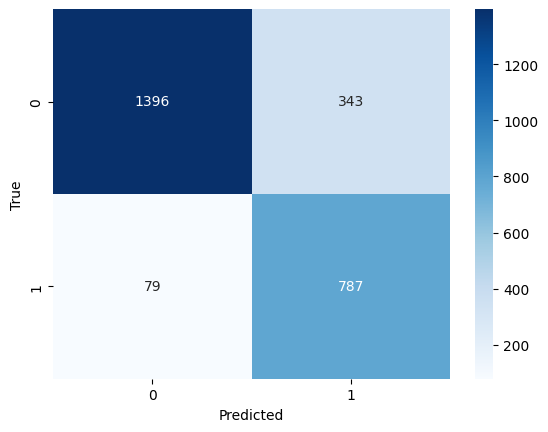

In [11]:
threshold = 0.5
true_labels = []
predicted_labels = []
for images,labels in test_ds:
    probabilities = binary_classifier.predict(images, verbose=0)[:,0]
    predicted_labels += list((probabilities > threshold).astype(int))
    true_labels += list(labels.numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predicted_labels)
print(f'Precision: {precision:.4f}')

recall = recall_score(true_labels, predicted_labels)
print(f'Recall: {recall:.4f}')

f1 = f1_score(true_labels, predicted_labels)
print(f'F1 Score: {f1:.4f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
